In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
import os

In [8]:
path_df = pd.read_csv('datasets/thyroid_ultrasonic_image/batch1_image/batch1_image.csv')
image_label = pd.read_csv('datasets/thyroid_ultrasonic_image/batch1_image/batch1_image_label.csv')
# Merge on patient name
merged_df = path_df.merge(image_label, on='patient_name', how='inner')

# Final structure
final_df = merged_df[['path', 'patient_name', 'histo_label']]
final_df = final_df.rename(columns={'path': 'image_path', 'histo_label': 'label'})
final_df['image_path'] = 'datasets/thyroid_ultrasonic_image/batch1_image/dataset/' + final_df['image_path']
print(final_df.head())

                                          image_path  patient_name  label
0  datasets/thyroid_ultrasonic_image/batch1_image...           341      0
1  datasets/thyroid_ultrasonic_image/batch1_image...           341      0
2  datasets/thyroid_ultrasonic_image/batch1_image...           341      0
3  datasets/thyroid_ultrasonic_image/batch1_image...           341      0
4  datasets/thyroid_ultrasonic_image/batch1_image...           341      0


In [14]:
test_path_df = pd.read_csv('datasets/thyroid_ultrasonic_image/batch2_image/batch2_image.csv')
image_label_test = pd.read_csv('datasets/thyroid_ultrasonic_image/batch2_image/batch2_image_label.csv')
# Merge on patient name
merged_df = test_path_df.merge(image_label_test, on='patient_name', how='inner')

# Final structure
test_df = merged_df[['path', 'patient_name', 'histo_label']]
test_df = test_df.rename(columns={'path': 'image_path', 'histo_label': 'label'})
test_df['image_path'] = 'datasets/thyroid_ultrasonic_image/batch2_image/dataset/' + test_df['image_path']
print(test_df.head())

                                          image_path  patient_name  label
0  datasets/thyroid_ultrasonic_image/batch2_image...           195      1
1  datasets/thyroid_ultrasonic_image/batch2_image...           195      1
2  datasets/thyroid_ultrasonic_image/batch2_image...           195      1
3  datasets/thyroid_ultrasonic_image/batch2_image...           195      1
4  datasets/thyroid_ultrasonic_image/batch2_image...           195      1


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create augmentation pipeline
def create_aug_pipeline():
    return ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
        preprocessing_function=lambda x: x/255.0
    )

In [16]:
cnn_model = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet', input_shape=(224, 224, 3))
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    return img_array  

In [19]:
from tqdm import tqdm
def extract_patient_features_augmented(df, aug_pipeline, num_augmentations=3):
    patient_features = []
    patient_labels = []
    
    grouped = df.groupby('patient_name')
    for patient, group in tqdm(grouped, desc="Extracting augmented patient features"):
        images = group['image_path'].tolist()
        label = group['label'].iloc[0]
        
        image_vecs = []
        for img_path in images:
            if not os.path.exists(img_path):
                continue
                
            try:
                # Load and preprocess original image
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                
                # Get features for original image
                feat = cnn_model.predict(img_array/255.0, verbose=0)
                image_vecs.append(feat[0])
                
                # Generate augmented versions
                aug_iter = aug_pipeline.flow(img_array, batch_size=1)
                for _ in range(num_augmentations):
                    aug_img = next(aug_iter)
                    aug_feat = cnn_model.predict(aug_img, verbose=0)
                    image_vecs.append(aug_feat[0])
                    
            except Exception as e:
                print(f"[ERROR] Problem with {img_path}: {e}")
                continue
                
        if len(image_vecs) == 0:
            print(f"[WARNING] No valid images for patient: {patient}, skipping")
            continue
            
        # Average all feature vectors (original + augmented)
        patient_vector = np.mean(image_vecs, axis=0)
        patient_features.append(patient_vector)
        patient_labels.append(label)
        
    return np.array(patient_features), np.array(patient_labels)

In [ ]:
aug_pipeline = create_aug_pipeline()
# Extract features with augmentation
X_train_aug, y_train_aug = extract_patient_features_augmented(final_df, aug_pipeline)
X_test_aug, y_test_aug = extract_patient_features_augmented(test_df, aug_pipeline)

Extracting augmented patient features:   0%|          | 0/601 [00:00<?, ?it/s]

Extracting augmented patient features:   1%|          | 4/601 [00:16<40:21,  4.06s/it]

[WARNING] No valid images for patient: 4, skipping


Extracting augmented patient features:   1%|▏         | 9/601 [00:31<35:12,  3.57s/it]

[WARNING] No valid images for patient: 9, skipping


Extracting augmented patient features:   2%|▏         | 12/601 [00:39<31:49,  3.24s/it]

[WARNING] No valid images for patient: 12, skipping


Extracting augmented patient features:   2%|▏         | 14/601 [00:47<34:50,  3.56s/it]

[WARNING] No valid images for patient: 14, skipping


Extracting augmented patient features:   3%|▎         | 16/601 [00:50<26:16,  2.70s/it]

[WARNING] No valid images for patient: 16, skipping


Extracting augmented patient features:   3%|▎         | 18/601 [00:56<27:23,  2.82s/it]

[WARNING] No valid images for patient: 18, skipping


Extracting augmented patient features:   4%|▍         | 25/601 [01:22<36:24,  3.79s/it]

[WARNING] No valid images for patient: 25, skipping


Extracting augmented patient features:   5%|▍         | 28/601 [01:37<43:27,  4.55s/it]

[WARNING] No valid images for patient: 28, skipping


Extracting augmented patient features:   7%|▋         | 44/601 [02:41<38:30,  4.15s/it]

[WARNING] No valid images for patient: 44, skipping


Extracting augmented patient features:   8%|▊         | 48/601 [02:52<29:35,  3.21s/it]

[WARNING] No valid images for patient: 48, skipping


Extracting augmented patient features:   8%|▊         | 50/601 [02:59<30:54,  3.37s/it]

[WARNING] No valid images for patient: 50, skipping


Extracting augmented patient features:  10%|█         | 63/601 [04:07<46:28,  5.18s/it]

[WARNING] No valid images for patient: 63, skipping


Extracting augmented patient features:  13%|█▎        | 79/601 [05:09<34:22,  3.95s/it]

[WARNING] No valid images for patient: 79, skipping


Extracting augmented patient features:  14%|█▍        | 86/601 [05:47<49:47,  5.80s/it]

[WARNING] No valid images for patient: 86, skipping


Extracting augmented patient features:  15%|█▍        | 90/601 [06:00<37:19,  4.38s/it]

[WARNING] No valid images for patient: 90, skipping


Extracting augmented patient features:  20%|██        | 121/601 [08:57<46:20,  5.79s/it]  

[WARNING] No valid images for patient: 121, skipping


Extracting augmented patient features:  24%|██▎       | 142/601 [10:33<24:41,  3.23s/it]

[WARNING] No valid images for patient: 142, skipping
[WARNING] No valid images for patient: 143, skipping


Extracting augmented patient features:  25%|██▍       | 149/601 [10:52<18:03,  2.40s/it]

[WARNING] No valid images for patient: 149, skipping


Extracting augmented patient features:  25%|██▌       | 152/601 [11:04<27:25,  3.67s/it]

[WARNING] No valid images for patient: 152, skipping


Extracting augmented patient features:  27%|██▋       | 160/601 [11:52<47:21,  6.44s/it]

[WARNING] No valid images for patient: 160, skipping


Extracting augmented patient features:  28%|██▊       | 166/601 [12:24<45:34,  6.29s/it]

[WARNING] No valid images for patient: 166, skipping


Extracting augmented patient features:  29%|██▉       | 175/601 [13:09<43:35,  6.14s/it]

[WARNING] No valid images for patient: 175, skipping
[WARNING] No valid images for patient: 176, skipping
[WARNING] No valid images for patient: 177, skipping


Extracting augmented patient features:  30%|███       | 181/601 [13:35<35:37,  5.09s/it]

[WARNING] No valid images for patient: 181, skipping


In [ ]:
np.save('datasets/X_train.npy', X_train_aug)
np.save('datasets/y_train.npy', y_train_aug)
np.save('dataset/X_test.npy', X_test_aug)
np.save('dataset/y_test.npy', y_test_aug)

Extracting patient features:   0%|          | 0/601 [00:00<?, ?it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/0_002.Jpg


Extracting patient features:   0%|          | 3/601 [00:03<12:20,  1.24s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/2_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/2_009.Jpg


Extracting patient features:   1%|          | 4/601 [00:04<11:54,  1.20s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/3_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/3_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/4_029.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/4_030.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/4_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/4_032.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/4_033.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/4_034.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/4_035.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/4_036.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/4_037.Jpg
[SKIPPED] Missing fil

Extracting patient features:   1%|          | 6/601 [00:05<07:40,  1.29it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/5_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/5_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/5_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/5_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/5_009.Jpg


Extracting patient features:   1%|          | 7/601 [00:06<07:16,  1.36it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/6_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/6_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/7_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/7_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/7_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/7_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/7_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/7_019.Jpg


Extracting patient features:   1%|▏         | 8/601 [00:08<11:38,  1.18s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/7_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/7_024.Jpg


Extracting patient features:   1%|▏         | 9/601 [00:09<10:48,  1.10s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/8_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/9_012.Jpg
[WARNING] No valid im

Extracting patient features:   2%|▏         | 11/601 [00:10<08:47,  1.12it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/10_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/10_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/10_010.Jpg


Extracting patient features:   2%|▏         | 12/601 [00:12<10:12,  1.04s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/11_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/11_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/11_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/11_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/12_030.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/12_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/12_032.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/12_033.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/12_034.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/12_036.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/12_037.Jpg
[SKIPPED] 

Extracting patient features:   2%|▏         | 14/601 [00:14<10:32,  1.08s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/13_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/13_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/13_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/14_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/14_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/14_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/14_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/14_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/14_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/14_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/14_008.Jpg
[SKIPPED] 

Extracting patient features:   3%|▎         | 16/601 [00:15<07:57,  1.23it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/15_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/15_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/16_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/16_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/16_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/16_013.Jpg
[WARNING] No valid images for patient: 16, skipping


Extracting patient features:   3%|▎         | 18/601 [00:16<07:54,  1.23it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/18_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/18_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/18_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/18_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/18_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/18_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/18_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/18_027.Jpg
[WARNING] No valid images for patient: 18, skipping


Extracting patient features:   4%|▎         | 22/601 [00:19<07:38,  1.26it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/21_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/21_005.Jpg


Extracting patient features:   4%|▍         | 23/601 [00:21<08:39,  1.11it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/22_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/22_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/22_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/22_013.Jpg


Extracting patient features:   4%|▍         | 24/601 [00:22<10:00,  1.04s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/23_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/23_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/23_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/24_001.Jpg


Extracting patient features:   4%|▍         | 25/601 [00:23<09:14,  1.04it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/24_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/24_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/25_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/25_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/25_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/25_004.Jpg
[WARNING] No valid images for patient: 25, skipping


Extracting patient features:   5%|▍         | 28/601 [00:27<12:01,  1.26s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/28_011.Jpg
[SKIPPED] 

Extracting patient features:   5%|▍         | 30/601 [00:29<10:37,  1.12s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/30_001.Jpg


Extracting patient features:   5%|▌         | 32/601 [00:31<10:55,  1.15s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/31_020.Jpg
[SKIPPED] 

Extracting patient features:   5%|▌         | 33/601 [00:32<10:43,  1.13s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/32_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/32_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/33_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/33_011.Jpg


Extracting patient features:   6%|▌         | 34/601 [00:34<12:14,  1.29s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/33_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/33_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/33_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/33_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/33_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/33_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/33_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/34_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/34_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/34_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/34_004.Jpg
[SKIPPED] 

Extracting patient features:   6%|▌         | 35/601 [00:36<13:11,  1.40s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/34_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/34_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/34_026.Jpg


Extracting patient features:   6%|▌         | 36/601 [00:36<11:13,  1.19s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/36_002.Jpg


Extracting patient features:   6%|▋         | 38/601 [00:38<10:10,  1.08s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/37_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/37_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/37_009.Jpg


Extracting patient features:   7%|▋         | 40/601 [00:43<15:06,  1.62s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/40_011.Jpg
[SKIPPED] 

Extracting patient features:   7%|▋         | 41/601 [00:43<12:11,  1.31s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/41_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/41_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/41_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/41_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/41_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/41_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/41_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/41_008.Jpg


Extracting patient features:   7%|▋         | 44/601 [00:47<12:13,  1.32s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/43_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_027.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_030.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_032.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_033.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_034.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_035.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_036.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/44_037.Jpg
[SKIPPED] 

Extracting patient features:   8%|▊         | 46/601 [00:48<09:24,  1.02s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/46_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/46_005.Jpg


Extracting patient features:   8%|▊         | 47/601 [00:50<10:16,  1.11s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/46_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/46_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/47_003.Jpg


Extracting patient features:   8%|▊         | 48/601 [00:51<09:31,  1.03s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/47_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/47_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/47_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/47_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/48_027.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/48_028.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/48_029.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/48_030.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/48_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/48_032.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/48_033.Jpg
[SKIPPED] 

Extracting patient features:   8%|▊         | 50/601 [00:54<11:07,  1.21s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/49_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/50_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/50_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/50_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/50_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/50_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/50_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/50_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/50_009.Jpg
[WARNING] No valid images for patient: 50, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/51_004.Jpg


Extracting patient features:   9%|▉         | 54/601 [00:59<12:33,  1.38s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/54_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/54_014.Jpg


Extracting patient features:   9%|▉         | 55/601 [01:02<16:21,  1.80s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/54_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/55_004.Jpg


Extracting patient features:  10%|▉         | 59/601 [01:10<15:42,  1.74s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/58_009.Jpg


Extracting patient features:  10%|▉         | 60/601 [01:11<14:30,  1.61s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/59_017.Jpg


Extracting patient features:  10%|█         | 62/601 [01:15<14:52,  1.66s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/61_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/61_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/61_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/61_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/61_013.Jpg


Extracting patient features:  10%|█         | 63/601 [01:16<13:35,  1.52s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/62_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/62_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/63_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/63_016.Jpg
[WARNING] No valid images for patient: 63, skipping


Extracting patient features:  11%|█         | 66/601 [01:17<07:39,  1.16it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/65_008.Jpg


Extracting patient features:  11%|█         | 67/601 [01:18<07:23,  1.20it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/66_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/66_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/66_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/66_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/66_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/66_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/66_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/66_018.Jpg


Extracting patient features:  11%|█▏        | 68/601 [01:18<06:40,  1.33it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/68_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/68_007.Jpg


Extracting patient features:  12%|█▏        | 70/601 [01:21<08:27,  1.05it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/69_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/69_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/69_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/69_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/69_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/69_018.Jpg


Extracting patient features:  12%|█▏        | 71/601 [01:22<08:58,  1.02s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/71_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/71_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/71_011.Jpg


Extracting patient features:  13%|█▎        | 76/601 [01:28<10:34,  1.21s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/75_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/75_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/75_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/75_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/75_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/75_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/75_013.Jpg


Extracting patient features:  13%|█▎        | 77/601 [01:29<10:00,  1.15s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/76_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/76_009.Jpg


Extracting patient features:  13%|█▎        | 78/601 [01:30<09:44,  1.12s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/78_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/78_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/78_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/78_004.Jpg


Extracting patient features:  13%|█▎        | 79/601 [01:31<07:55,  1.10it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/79_045.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/79_046.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/79_047.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/79_048.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/79_049.Jpg
[WARNING] No valid images for patient: 79, skipping


Extracting patient features:  13%|█▎        | 81/601 [01:33<08:59,  1.04s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/80_016.Jpg


Extracting patient features:  14%|█▎        | 82/601 [01:35<10:14,  1.18s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/81_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/81_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/81_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/81_013.Jpg


Extracting patient features:  14%|█▍        | 83/601 [01:35<08:55,  1.03s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/82_014.Jpg
[SKIPPED] 

Extracting patient features:  14%|█▍        | 84/601 [01:36<09:04,  1.05s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/83_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/83_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/83_009.Jpg


Extracting patient features:  14%|█▍        | 85/601 [01:38<10:13,  1.19s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/84_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/84_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/84_011.Jpg


Extracting patient features:  14%|█▍        | 86/601 [01:40<12:46,  1.49s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/86_027.Jpg
[SKIPPED] 

Extracting patient features:  15%|█▍        | 88/601 [01:41<07:52,  1.09it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/87_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/87_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/87_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/87_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/87_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/87_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/87_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/87_020.Jpg


Extracting patient features:  15%|█▍        | 89/601 [01:43<10:32,  1.24s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/88_021.Jpg
[SKIPPED] 

Extracting patient features:  15%|█▍        | 90/601 [01:43<09:16,  1.09s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/89_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/89_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/89_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/89_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/89_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/89_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/89_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/90_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/90_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/90_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/90_004.Jpg
[SKIPPED] 

Extracting patient features:  15%|█▌        | 93/601 [01:48<10:37,  1.25s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/92_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/92_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/92_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/92_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/92_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/92_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/92_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/92_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/92_016.Jpg


Extracting patient features:  16%|█▌        | 94/601 [01:49<11:31,  1.36s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/93_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/93_013.Jpg


Extracting patient features:  16%|█▌        | 95/601 [01:50<09:37,  1.14s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/94_019.Jpg


Extracting patient features:  16%|█▌        | 96/601 [01:51<10:52,  1.29s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/95_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/95_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/95_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/95_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/95_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/95_014.Jpg


Extracting patient features:  16%|█▌        | 97/601 [01:53<11:55,  1.42s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/96_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/96_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/96_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/96_013.Jpg


Extracting patient features:  17%|█▋        | 100/601 [01:59<15:34,  1.87s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/99_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/99_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/99_023.Jpg


Extracting patient features:  17%|█▋        | 101/601 [02:02<16:12,  1.95s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/100_012.Jpg


Extracting patient features:  17%|█▋        | 102/601 [02:03<15:22,  1.85s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/101_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/101_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/101_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/101_013.Jpg


Extracting patient features:  17%|█▋        | 103/601 [02:04<13:36,  1.64s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/103_011.Jpg

Extracting patient features:  17%|█▋        | 104/601 [02:05<10:21,  1.25s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/104_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/104_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/104_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/104_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/104_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/104_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/104_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/104_009.Jpg


Extracting patient features:  18%|█▊        | 106/601 [02:06<07:49,  1.05it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/105_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/105_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/105_007.Jpg


Extracting patient features:  18%|█▊        | 107/601 [02:07<08:00,  1.03it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/106_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/106_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/106_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/106_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/106_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/106_014.Jpg


Extracting patient features:  18%|█▊        | 110/601 [02:09<06:07,  1.34it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/109_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/109_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/109_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/109_007.Jpg


Extracting patient features:  18%|█▊        | 111/601 [02:10<07:40,  1.06it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/110_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/110_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/110_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/110_012.Jpg


Extracting patient features:  19%|█▊        | 112/601 [02:12<10:16,  1.26s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/111_016.Jpg


Extracting patient features:  19%|█▉        | 115/601 [02:16<09:10,  1.13s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/114_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/114_015.Jpg


Extracting patient features:  19%|█▉        | 116/601 [02:17<09:03,  1.12s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/116_007.Jpg


Extracting patient features:  19%|█▉        | 117/601 [02:18<09:29,  1.18s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/116_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/116_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/116_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/117_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/117_006.Jpg


Extracting patient features:  20%|█▉        | 118/601 [02:19<09:49,  1.22s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/117_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/117_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/117_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/117_014.Jpg


Extracting patient features:  20%|██        | 121/601 [02:23<10:10,  1.27s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/120_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/121_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/121_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/121_019.Jpg
[WARNING] No valid images for patient: 121, skipping


Extracting patient features:  21%|██        | 124/601 [02:25<07:21,  1.08it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/123_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/123_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/123_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/123_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/124_003.Jpg


Extracting patient features:  21%|██        | 125/601 [02:27<08:24,  1.06s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/124_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/124_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/124_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/124_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/124_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/124_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/124_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/124_018.Jpg


Extracting patient features:  21%|██▏       | 128/601 [02:30<07:55,  1.01s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/127_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/127_017.Jpg


Extracting patient features:  21%|██▏       | 129/601 [02:31<08:54,  1.13s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/128_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/128_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/128_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/128_012.Jpg


Extracting patient features:  22%|██▏       | 130/601 [02:32<08:44,  1.11s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/129_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/129_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/129_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/129_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/129_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/129_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/130_013.Jpg


Extracting patient features:  22%|██▏       | 131/601 [02:35<11:49,  1.51s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/130_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/130_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/130_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/130_023.Jpg


Extracting patient features:  22%|██▏       | 133/601 [02:37<11:22,  1.46s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/132_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/132_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/132_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/132_016.Jpg


Extracting patient features:  22%|██▏       | 134/601 [02:39<10:43,  1.38s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/133_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/133_009.Jpg


Extracting patient features:  23%|██▎       | 136/601 [02:41<08:52,  1.15s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/135_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/135_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/135_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/135_011.Jpg


Extracting patient features:  23%|██▎       | 137/601 [02:41<08:20,  1.08s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/136_019.Jpg

Extracting patient features:  23%|██▎       | 138/601 [02:42<08:13,  1.07s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/137_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/137_009.Jpg


Extracting patient features:  23%|██▎       | 140/601 [02:45<09:16,  1.21s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/139_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/139_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/139_011.Jpg


Extracting patient features:  24%|██▎       | 142/601 [02:46<06:26,  1.19it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/141_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/142_001.Jpg

Extracting patient features:  24%|██▍       | 145/601 [02:48<05:58,  1.27it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/144_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/144_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/144_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/144_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/144_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/144_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/144_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/144_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/144_022.Jpg


Extracting patient features:  24%|██▍       | 146/601 [02:49<06:17,  1.21it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/145_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/145_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/145_008.Jpg


Extracting patient features:  25%|██▍       | 148/601 [02:51<05:42,  1.32it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/147_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/147_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/147_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/147_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/147_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/147_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/147_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/147_021.Jpg


Extracting patient features:  25%|██▍       | 149/601 [02:51<05:05,  1.48it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/148_015.Jpg

Extracting patient features:  25%|██▌       | 151/601 [02:52<04:32,  1.65it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/150_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/150_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/150_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/150_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/150_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/150_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/150_015.Jpg


Extracting patient features:  25%|██▌       | 152/601 [02:55<08:00,  1.07s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/151_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/151_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/152_030.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/152_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/152_032.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/152_033.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/152_034.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/152_035.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/152_036.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/152_037.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/152_038.Jpg

Extracting patient features:  26%|██▌       | 154/601 [02:57<07:25,  1.00it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/153_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/153_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/154_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/154_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/154_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/154_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/154_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/154_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/154_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/154_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/154_009.Jpg

Extracting patient features:  26%|██▌       | 155/601 [02:58<07:51,  1.06s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/155_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/155_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/155_012.Jpg


Extracting patient features:  26%|██▌       | 156/601 [03:00<09:28,  1.28s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/155_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/156_010.Jpg


Extracting patient features:  26%|██▋       | 158/601 [03:03<10:02,  1.36s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/157_007.Jpg


Extracting patient features:  26%|██▋       | 159/601 [03:06<13:17,  1.80s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/158_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/158_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/158_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/158_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/158_020.Jpg


Extracting patient features:  27%|██▋       | 160/601 [03:07<12:46,  1.74s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/159_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/159_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/159_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/159_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/160_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/160_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/160_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/160_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/160_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/160_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/160_007.Jpg

Extracting patient features:  27%|██▋       | 162/601 [03:09<10:10,  1.39s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/161_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/161_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/161_016.Jpg


Extracting patient features:  27%|██▋       | 163/601 [03:10<08:36,  1.18s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/162_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/162_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/162_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/162_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/162_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/162_013.Jpg


Extracting patient features:  28%|██▊       | 166/601 [03:14<10:17,  1.42s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/166_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/166_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/166_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/166_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/166_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/166_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/166_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/166_022.Jpg
[WARNING] No valid images for patient: 166, skipping


Extracting patient features:  28%|██▊       | 168/601 [03:15<07:27,  1.03s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/168_003.Jpg


Extracting patient features:  28%|██▊       | 169/601 [03:16<07:25,  1.03s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/168_007.Jpg


Extracting patient features:  28%|██▊       | 170/601 [03:17<06:30,  1.10it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/169_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/169_005.Jpg


Extracting patient features:  29%|██▊       | 172/601 [03:20<09:30,  1.33s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/172_006.Jpg


Extracting patient features:  29%|██▉       | 175/601 [03:25<09:51,  1.39s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/175_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/175_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/175_003.Jpg
[WARNING] No valid images for patient: 175, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/176_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/176_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/176_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/176_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/176_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/176_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/176_007.Jpg
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  30%|██▉       | 179/601 [03:26<05:13,  1.35it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/179_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/179_008.Jpg


Extracting patient features:  30%|███       | 181/601 [03:29<06:33,  1.07it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/180_016.Jpg

Extracting patient features:  30%|███       | 183/601 [03:30<04:34,  1.53it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/182_013.Jpg

Extracting patient features:  31%|███       | 185/601 [03:31<04:29,  1.54it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/184_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/184_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/184_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/184_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/184_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/184_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/184_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/184_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/184_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/185_005.Jpg


Extracting patient features:  31%|███       | 187/601 [03:33<05:13,  1.32it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/186_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/187_001.Jpg

Extracting patient features:  31%|███▏      | 189/601 [03:35<06:18,  1.09it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/188_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/188_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/188_017.Jpg


Extracting patient features:  32%|███▏      | 194/601 [03:44<11:13,  1.66s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_076.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_077.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_078.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_079.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_080.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_081.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_082.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_083.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_084.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_085.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/194_087.Jpg

Extracting patient features:  33%|███▎      | 198/601 [03:46<05:57,  1.13it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/197_014.Jpg

Extracting patient features:  33%|███▎      | 199/601 [03:47<06:01,  1.11it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/198_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/198_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/198_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/198_009.Jpg


Extracting patient features:  33%|███▎      | 201/601 [03:49<05:49,  1.14it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/200_023.Jpg

Extracting patient features:  34%|███▍      | 204/601 [03:50<03:36,  1.83it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/202_025.Jpg

Extracting patient features:  34%|███▍      | 206/601 [03:53<06:08,  1.07it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/205_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/205_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/205_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/205_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/205_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/205_016.Jpg


Extracting patient features:  35%|███▍      | 208/601 [03:55<06:14,  1.05it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/207_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/207_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/207_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/207_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/207_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/207_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/207_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/208_002.Jpg


Extracting patient features:  35%|███▍      | 209/601 [03:55<05:17,  1.23it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/209_023.Jpg
[WARNING] No valid images for patient: 209, skipping
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  35%|███▌      | 211/601 [03:57<04:41,  1.39it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/210_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/210_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/210_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/210_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/210_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/211_009.Jpg


Extracting patient features:  35%|███▌      | 212/601 [03:58<06:12,  1.05it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/211_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/211_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/211_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/211_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/211_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/211_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/211_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/212_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/212_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/212_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/212_019.Jpg

Extracting patient features:  36%|███▌      | 215/601 [04:01<06:11,  1.04it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/214_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/214_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/214_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/214_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/214_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/214_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/214_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/214_018.Jpg


Extracting patient features:  36%|███▌      | 216/601 [04:02<06:45,  1.05s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/215_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/215_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/215_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/215_015.Jpg


Extracting patient features:  36%|███▌      | 217/601 [04:03<05:53,  1.09it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/217_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/217_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/217_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/217_027.Jpg
[WARNING] No valid images for patient: 217, skipping


Extracting patient features:  36%|███▋      | 219/601 [04:04<04:30,  1.41it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/218_020.Jpg

Extracting patient features:  37%|███▋      | 221/601 [04:06<06:13,  1.02it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/221_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/221_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/221_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/221_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/221_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/221_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/221_027.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/221_028.Jpg
[WARNING] No valid images for patient: 221, skipping


Extracting patient features:  37%|███▋      | 223/601 [04:07<05:13,  1.21it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/223_008.Jpg


Extracting patient features:  37%|███▋      | 224/601 [04:09<06:31,  1.04s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/223_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/224_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/224_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/224_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/224_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/224_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/224_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/224_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/224_010.Jpg
[WARNING] No valid images for patient: 224, skipping


Extracting patient features:  38%|███▊      | 226/601 [04:10<05:11,  1.20it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/225_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/225_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/226_005.Jpg


Extracting patient features:  38%|███▊      | 227/601 [04:11<04:36,  1.35it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/226_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/226_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/226_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/227_034.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/227_035.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/227_036.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/227_037.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/227_038.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/227_039.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/227_040.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/227_041.Jpg

Extracting patient features:  38%|███▊      | 229/601 [04:11<03:23,  1.83it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/228_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/228_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/228_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/228_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/228_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/228_009.Jpg


Extracting patient features:  38%|███▊      | 230/601 [04:13<04:41,  1.32it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/230_023.Jpg

Extracting patient features:  39%|███▊      | 232/601 [04:14<04:09,  1.48it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/231_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/231_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/231_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/231_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/231_011.Jpg


Extracting patient features:  39%|███▉      | 234/601 [04:15<03:54,  1.57it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/233_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/233_004.Jpg


Extracting patient features:  39%|███▉      | 237/601 [04:19<06:47,  1.12s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/236_017.Jpg

Extracting patient features:  40%|███▉      | 238/601 [04:21<07:51,  1.30s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/237_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/237_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/237_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/237_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/237_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/238_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/238_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/238_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/238_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/238_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/238_006.Jpg

Extracting patient features:  40%|████      | 241/601 [04:23<05:43,  1.05it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/240_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/240_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/240_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/240_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/240_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/240_016.Jpg


Extracting patient features:  40%|████      | 242/601 [04:25<06:28,  1.08s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/241_007.Jpg


Extracting patient features:  41%|████      | 245/601 [04:29<08:20,  1.41s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/244_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/244_013.Jpg


Extracting patient features:  41%|████      | 247/601 [04:33<08:43,  1.48s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/246_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/246_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/246_009.Jpg


Extracting patient features:  41%|████▏     | 248/601 [04:33<07:17,  1.24s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/247_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/247_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/247_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/247_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/247_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/247_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/247_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/247_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/248_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/248_007.Jpg


Extracting patient features:  41%|████▏     | 249/601 [04:35<08:45,  1.49s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/249_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/249_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/249_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/249_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/249_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/249_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/249_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/249_011.Jpg
[WARNING] No valid images for patient: 249, skipping


Extracting patient features:  42%|████▏     | 252/601 [04:39<07:37,  1.31s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/251_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/251_013.Jpg


Extracting patient features:  42%|████▏     | 254/601 [04:42<08:35,  1.49s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/253_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/253_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/254_030.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/254_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/254_032.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/254_033.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/254_034.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/254_036.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/254_037.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/254_038.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/254_039.Jpg

Extracting patient features:  43%|████▎     | 256/601 [04:43<06:07,  1.06s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/255_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/255_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/255_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/255_009.Jpg


Extracting patient features:  43%|████▎     | 258/601 [04:45<06:21,  1.11s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/257_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/257_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/257_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/257_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/257_014.Jpg


Extracting patient features:  43%|████▎     | 260/601 [04:48<06:37,  1.17s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/259_017.Jpg


Extracting patient features:  44%|████▎     | 262/601 [04:52<08:53,  1.57s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_027.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_028.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_029.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/262_030.Jpg

Extracting patient features:  44%|████▍     | 264/601 [04:53<05:51,  1.04s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/263_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/263_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/263_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/263_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/263_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/263_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/263_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/263_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/263_015.Jpg


Extracting patient features:  44%|████▍     | 265/601 [04:54<05:43,  1.02s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/264_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/264_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/264_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/264_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/264_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/264_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/264_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/264_012.Jpg


Extracting patient features:  44%|████▍     | 266/601 [04:55<06:16,  1.12s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/265_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/265_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/265_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/265_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/265_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/265_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/265_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/265_014.Jpg


Extracting patient features:  44%|████▍     | 267/601 [04:55<05:14,  1.06it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/266_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/266_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/266_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_010.Jpg


Extracting patient features:  45%|████▍     | 268/601 [04:57<06:38,  1.20s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/267_024.Jpg

Extracting patient features:  45%|████▍     | 269/601 [04:58<06:28,  1.17s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/269_035.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/269_036.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/269_037.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/269_038.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/269_039.Jpg
[WARNING] No valid images for patient: 269, skipping


Extracting patient features:  46%|████▌     | 275/601 [05:05<06:52,  1.26s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/275_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/275_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/275_010.Jpg


Extracting patient features:  46%|████▋     | 278/601 [05:08<05:38,  1.05s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/277_017.Jpg

Extracting patient features:  47%|████▋     | 281/601 [05:12<06:19,  1.19s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/281_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/281_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/281_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/281_004.Jpg
[WARNING] No valid images for patient: 281, skipping


Extracting patient features:  47%|████▋     | 284/601 [05:14<04:12,  1.26it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/283_003.Jpg


Extracting patient features:  47%|████▋     | 285/601 [05:15<04:38,  1.13it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/284_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/284_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/284_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/284_010.Jpg


Extracting patient features:  48%|████▊     | 287/601 [05:17<05:33,  1.06s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/287_003.Jpg


Extracting patient features:  48%|████▊     | 288/601 [05:18<05:21,  1.03s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/287_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/287_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/287_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/287_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/288_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/288_002.Jpg
[WARNING] No valid images for patient: 288, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/289_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/289_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/289_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/289_026.Jpg
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  49%|████▉     | 294/601 [05:20<02:58,  1.72it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_030.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_032.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_033.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_034.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_035.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_038.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_039.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_040.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_043.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/294_044.Jpg

Extracting patient features:  49%|████▉     | 297/601 [05:21<02:14,  2.26it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/297_004.Jpg


Extracting patient features:  50%|████▉     | 299/601 [05:25<04:13,  1.19it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/298_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/298_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/298_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/298_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/298_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/298_015.Jpg


Extracting patient features:  50%|████▉     | 300/601 [05:26<04:31,  1.11it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/299_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/299_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/299_012.Jpg


Extracting patient features:  50%|█████     | 301/601 [05:27<04:51,  1.03it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/300_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/300_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/301_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/301_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/301_007.Jpg


Extracting patient features:  50%|█████     | 302/601 [05:28<04:36,  1.08it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/301_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/301_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/301_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/301_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/301_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/302_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/302_006.Jpg


Extracting patient features:  50%|█████     | 303/601 [05:28<04:29,  1.11it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/302_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/302_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/302_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/302_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/302_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/302_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/302_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/303_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/303_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/303_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/303_004.Jpg

Extracting patient features:  51%|█████     | 305/601 [05:30<03:48,  1.29it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/304_015.Jpg

Extracting patient features:  51%|█████     | 306/601 [05:30<03:27,  1.42it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/305_004.Jpg


Extracting patient features:  51%|█████     | 307/601 [05:31<03:00,  1.63it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/306_017.Jpg

Extracting patient features:  51%|█████     | 308/601 [05:32<04:23,  1.11it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/308_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/308_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/308_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/308_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/308_005.Jpg


Extracting patient features:  52%|█████▏    | 310/601 [05:34<04:04,  1.19it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/310_011.Jpg


Extracting patient features:  52%|█████▏    | 311/601 [05:36<05:56,  1.23s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/310_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/310_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/310_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/310_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/310_019.Jpg


Extracting patient features:  52%|█████▏    | 312/601 [05:37<05:46,  1.20s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/311_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/311_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/311_009.Jpg


Extracting patient features:  52%|█████▏    | 313/601 [05:38<05:19,  1.11s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/313_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/313_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/313_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/313_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/313_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/313_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/313_026.Jpg
[WARNING] No valid images for patient: 313, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/314_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/314_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/314_003.Jpg
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  53%|█████▎    | 318/601 [05:40<02:51,  1.65it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/318_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/318_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/318_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/318_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/318_019.Jpg
[WARNING] No valid images for patient: 318, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/319_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/319_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/319_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/319_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/319_005.Jpg
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  53%|█████▎    | 321/601 [05:41<02:31,  1.85it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/320_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/320_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/321_007.Jpg


Extracting patient features:  54%|█████▍    | 324/601 [05:47<05:03,  1.09s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/323_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/323_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/323_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/323_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/323_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/324_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/324_008.Jpg


Extracting patient features:  54%|█████▍    | 325/601 [05:48<05:03,  1.10s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/324_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/324_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/324_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/324_015.Jpg


Extracting patient features:  54%|█████▍    | 326/601 [05:49<05:06,  1.11s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/325_017.Jpg

Extracting patient features:  54%|█████▍    | 327/601 [05:52<07:52,  1.72s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/327_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/327_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/327_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/327_004.Jpg


Extracting patient features:  55%|█████▍    | 328/601 [05:53<06:14,  1.37s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/328_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/328_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/328_003.Jpg
[WARNING] No valid images for patient: 328, skipping


Extracting patient features:  55%|█████▍    | 330/601 [05:54<04:55,  1.09s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/329_008.Jpg


Extracting patient features:  55%|█████▌    | 331/601 [05:56<06:05,  1.35s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/331_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/331_018.Jpg
[WARNING] No valid images for patient: 331, skipping


Extracting patient features:  56%|█████▌    | 334/601 [06:00<06:17,  1.41s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/333_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/333_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/333_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/333_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/333_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/334_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/334_032.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/334_033.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/334_034.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/334_035.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/334_036.Jpg

Extracting patient features:  56%|█████▌    | 338/601 [06:05<05:16,  1.20s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/337_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/337_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/337_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/337_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/337_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/337_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/337_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/337_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/338_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/338_009.Jpg


Extracting patient features:  56%|█████▋    | 339/601 [06:07<06:36,  1.51s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/339_004.Jpg


Extracting patient features:  57%|█████▋    | 340/601 [06:08<06:06,  1.41s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/340_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/340_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/340_028.Jpg
[WARNING] No valid images for patient: 340, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/341_007.Jpg


Extracting patient features:  57%|█████▋    | 342/601 [06:09<04:40,  1.08s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/342_001.Jpg
[WARNING] No valid images for patient: 342, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/343_004.Jpg


Extracting patient features:  57%|█████▋    | 344/601 [06:11<04:04,  1.05it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/343_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/343_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/343_012.Jpg


Extracting patient features:  58%|█████▊    | 346/601 [06:14<05:12,  1.23s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/346_002.Jpg


Extracting patient features:  58%|█████▊    | 347/601 [06:15<04:36,  1.09s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/346_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/346_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/346_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/346_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/346_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/346_010.Jpg


Extracting patient features:  58%|█████▊    | 348/601 [06:16<04:00,  1.05it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/347_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/347_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/347_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/347_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/347_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/347_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/347_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/347_011.Jpg


Extracting patient features:  58%|█████▊    | 349/601 [06:17<04:26,  1.06s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/348_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/348_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/348_010.Jpg


Extracting patient features:  58%|█████▊    | 350/601 [06:19<05:05,  1.22s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/349_009.Jpg


Extracting patient features:  58%|█████▊    | 351/601 [06:20<04:47,  1.15s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/351_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/351_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/351_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/351_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/351_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/351_027.Jpg
[WARNING] No valid images for patient: 351, skipping


Extracting patient features:  59%|█████▊    | 353/601 [06:22<04:37,  1.12s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/352_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/352_015.Jpg


Extracting patient features:  59%|█████▉    | 354/601 [06:23<04:11,  1.02s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/353_016.Jpg

Extracting patient features:  59%|█████▉    | 357/601 [06:26<04:08,  1.02s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/356_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/356_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/356_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/356_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/356_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/356_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/356_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/356_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/356_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/357_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/357_002.Jpg

Extracting patient features:  60%|██████    | 361/601 [06:30<04:31,  1.13s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/360_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/360_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/360_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/360_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/360_011.Jpg


Extracting patient features:  60%|██████    | 362/601 [06:30<03:29,  1.14it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/361_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/361_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/361_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/361_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/361_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/361_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/361_025.Jpg


Extracting patient features:  61%|██████    | 364/601 [06:32<03:22,  1.17it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/363_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/363_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/363_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/363_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/363_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/363_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/363_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/363_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/363_021.Jpg


Extracting patient features:  61%|██████    | 366/601 [06:34<03:52,  1.01it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/365_020.Jpg


Extracting patient features:  61%|██████    | 367/601 [06:35<03:55,  1.01s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/367_011.Jpg
[WARNING] No valid images for patient: 367, skipping


Extracting patient features:  62%|██████▏   | 370/601 [06:38<03:28,  1.11it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/370_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/370_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/370_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/370_004.Jpg
[WARNING] No valid images for patient: 370, skipping


Extracting patient features:  62%|██████▏   | 372/601 [06:38<02:35,  1.47it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/372_011.Jpg

Extracting patient features:  62%|██████▏   | 374/601 [06:39<02:16,  1.66it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/374_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/374_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/374_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/374_006.Jpg


Extracting patient features:  62%|██████▏   | 375/601 [06:41<03:03,  1.23it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/374_014.Jpg


Extracting patient features:  63%|██████▎   | 376/601 [06:42<03:40,  1.02it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/375_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/375_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/375_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/375_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/375_015.Jpg


Extracting patient features:  63%|██████▎   | 377/601 [06:43<03:29,  1.07it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/376_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/376_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/376_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/376_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/377_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/377_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/377_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/377_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/377_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/377_027.Jpg
[WARNING] No valid images for patient: 377, skipping


Extracting patient features:  63%|██████▎   | 379/601 [06:45<03:34,  1.04it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/379_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/379_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/379_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/379_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/379_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/379_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/379_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/379_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/379_011.Jpg
[WARNING] No valid images for patient: 379, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/380_010.Jpg
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  64%|██████▎   | 382/601 [06:46<02:17,  1.59it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/381_005.Jpg


Extracting patient features:  64%|██████▎   | 383/601 [06:48<03:10,  1.15it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/382_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/382_016.Jpg


Extracting patient features:  64%|██████▍   | 384/601 [06:50<03:55,  1.09s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/383_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/383_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/383_013.Jpg


Extracting patient features:  64%|██████▍   | 386/601 [06:51<03:29,  1.02it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/385_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/385_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/385_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/385_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/385_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/386_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/386_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/386_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/386_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/386_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/386_006.Jpg

Extracting patient features:  65%|██████▍   | 388/601 [06:53<02:51,  1.24it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/387_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/387_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/387_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/387_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/387_012.Jpg


Extracting patient features:  65%|██████▌   | 391/601 [06:57<03:48,  1.09s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/390_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/391_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/391_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/391_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/391_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/391_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/391_007.Jpg
[WARNING] No valid images for patient: 391, skipping


Extracting patient features:  65%|██████▌   | 393/601 [06:58<03:03,  1.13it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/392_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/392_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/392_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/392_011.Jpg


Extracting patient features:  66%|██████▌   | 394/601 [06:59<02:53,  1.19it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/394_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/394_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/394_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/394_024.Jpg


Extracting patient features:  66%|██████▌   | 396/601 [07:00<02:34,  1.33it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/396_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/396_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/396_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/396_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/396_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/396_006.Jpg
[WARNING] No valid images for patient: 396, skipping


Extracting patient features:  66%|██████▌   | 398/601 [07:01<02:04,  1.62it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/397_006.Jpg


Extracting patient features:  66%|██████▋   | 399/601 [07:01<02:09,  1.57it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/398_005.Jpg


Extracting patient features:  67%|██████▋   | 400/601 [07:03<03:02,  1.10it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/400_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/400_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/400_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/400_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/400_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/400_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/400_007.Jpg
[WARNING] No valid images for patient: 400, skipping


Extracting patient features:  67%|██████▋   | 402/601 [07:04<02:35,  1.28it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/401_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/401_008.Jpg


Extracting patient features:  67%|██████▋   | 403/601 [07:06<03:13,  1.02it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/403_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/403_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/403_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/403_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/403_005.Jpg
[WARNING] No valid images for patient: 403, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/404_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/404_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/404_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/404_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/404_005.Jpg
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  68%|██████▊   | 406/601 [07:07<02:23,  1.36it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/405_008.Jpg


Extracting patient features:  68%|██████▊   | 407/601 [07:10<03:17,  1.02s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/407_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/407_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/407_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/407_027.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/407_028.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/407_029.Jpg
[WARNING] No valid images for patient: 407, skipping


Extracting patient features:  68%|██████▊   | 409/601 [07:10<02:31,  1.26it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/409_004.Jpg


Extracting patient features:  68%|██████▊   | 411/601 [07:13<03:11,  1.01s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/410_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/410_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/410_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/410_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/410_012.Jpg


Extracting patient features:  69%|██████▉   | 414/601 [07:18<04:03,  1.30s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/413_017.Jpg

Extracting patient features:  69%|██████▉   | 416/601 [07:22<05:06,  1.66s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/415_020.Jpg

Extracting patient features:  69%|██████▉   | 417/601 [07:23<04:05,  1.33s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/416_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/416_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/416_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/416_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/416_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/417_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/417_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/417_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/417_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/417_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/417_006.Jpg

Extracting patient features:  70%|██████▉   | 420/601 [07:24<02:36,  1.16it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_007.Jpg


Extracting patient features:  70%|███████   | 421/601 [07:25<02:37,  1.15it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/420_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/421_003.Jpg


Extracting patient features:  70%|███████   | 423/601 [07:26<02:17,  1.29it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/422_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/422_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/422_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/422_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/422_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/422_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/422_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/422_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/422_013.Jpg


Extracting patient features:  71%|███████   | 426/601 [07:29<02:04,  1.40it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/425_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/425_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/425_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/425_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/425_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/425_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/426_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/426_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/426_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/426_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/426_005.Jpg

Extracting patient features:  71%|███████   | 428/601 [07:30<01:55,  1.50it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/428_011.Jpg

Extracting patient features:  72%|███████▏  | 430/601 [07:32<01:56,  1.47it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/429_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/429_011.Jpg


Extracting patient features:  72%|███████▏  | 431/601 [07:32<02:04,  1.37it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/430_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/430_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/430_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/430_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/430_010.Jpg


Extracting patient features:  72%|███████▏  | 432/601 [07:34<02:33,  1.10it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/431_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/431_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/431_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/431_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/431_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/431_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/431_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/431_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/431_022.Jpg


Extracting patient features:  72%|███████▏  | 433/601 [07:35<02:29,  1.12it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/432_005.Jpg


Extracting patient features:  72%|███████▏  | 434/601 [07:36<02:56,  1.06s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/433_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/433_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/433_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/433_013.Jpg


Extracting patient features:  72%|███████▏  | 435/601 [07:37<02:39,  1.04it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/434_014.Jpg

Extracting patient features:  73%|███████▎  | 436/601 [07:38<02:57,  1.08s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/435_021.Jpg

Extracting patient features:  73%|███████▎  | 438/601 [07:41<03:27,  1.27s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/437_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/437_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/437_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/437_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/437_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/437_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/437_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/438_029.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/438_030.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/438_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/438_032.Jpg

Extracting patient features:  73%|███████▎  | 440/601 [07:44<03:18,  1.23s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/440_003.Jpg


Extracting patient features:  73%|███████▎  | 441/601 [07:45<03:19,  1.24s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/440_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/441_004.Jpg


Extracting patient features:  74%|███████▎  | 442/601 [07:46<03:04,  1.16s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/442_002.Jpg


Extracting patient features:  74%|███████▎  | 443/601 [07:48<03:47,  1.44s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/442_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/442_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/443_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/443_006.Jpg


Extracting patient features:  74%|███████▍  | 446/601 [07:52<03:03,  1.19s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/445_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/445_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/445_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/445_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/445_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/445_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/445_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/445_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/445_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/446_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/446_012.Jpg

Extracting patient features:  75%|███████▍  | 448/601 [07:52<02:01,  1.26it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/448_012.Jpg


Extracting patient features:  75%|███████▍  | 449/601 [07:55<03:01,  1.19s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/448_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/448_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/448_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/448_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/448_020.Jpg


Extracting patient features:  75%|███████▌  | 451/601 [07:56<02:06,  1.19it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/450_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/450_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/450_015.Jpg


Extracting patient features:  75%|███████▌  | 452/601 [07:57<02:39,  1.07s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/451_010.Jpg


Extracting patient features:  76%|███████▌  | 454/601 [07:59<02:33,  1.05s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/454_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/454_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/454_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/454_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/454_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/454_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/454_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/454_024.Jpg
[WARNING] No valid images for patient: 454, skipping


Extracting patient features:  76%|███████▌  | 456/601 [08:00<01:37,  1.48it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/455_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/455_005.Jpg


Extracting patient features:  76%|███████▌  | 457/601 [08:02<02:44,  1.14s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/457_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/457_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/457_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/457_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/457_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/457_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/457_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/457_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/457_012.Jpg
[WARNING] No valid images for patient: 457, skipping


Extracting patient features:  76%|███████▋  | 459/601 [08:04<02:10,  1.09it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/458_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/458_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/458_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/458_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/458_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/458_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/458_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/458_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/458_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/459_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/459_002.Jpg

Extracting patient features:  77%|███████▋  | 461/601 [08:07<02:47,  1.20s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/461_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/461_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/461_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/461_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/461_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/461_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/461_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/461_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/461_009.Jpg
[WARNING] No valid images for patient: 461, skipping


Extracting patient features:  77%|███████▋  | 463/601 [08:08<02:10,  1.06it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/462_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/462_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/462_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/462_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/462_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/462_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/462_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/463_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/463_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/463_014.Jpg


Extracting patient features:  77%|███████▋  | 464/601 [08:09<02:23,  1.05s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/463_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/463_016.Jpg


Extracting patient features:  77%|███████▋  | 465/601 [08:11<02:36,  1.15s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/464_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/464_010.Jpg


Extracting patient features:  78%|███████▊  | 467/601 [08:13<02:24,  1.08s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/467_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/467_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/467_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/467_020.Jpg
[WARNING] No valid images for patient: 467, skipping


Extracting patient features:  78%|███████▊  | 469/601 [08:14<02:14,  1.02s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/468_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/468_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/468_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/468_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/468_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/468_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/468_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/469_007.Jpg


Extracting patient features:  78%|███████▊  | 470/601 [08:16<02:34,  1.18s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/469_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/469_012.Jpg


Extracting patient features:  78%|███████▊  | 471/601 [08:18<02:38,  1.22s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/470_008.Jpg


Extracting patient features:  79%|███████▊  | 472/601 [08:19<02:55,  1.36s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/471_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/471_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/471_010.Jpg


Extracting patient features:  79%|███████▊  | 473/601 [08:20<02:41,  1.26s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/472_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/472_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/472_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/472_009.Jpg


Extracting patient features:  79%|███████▉  | 474/601 [08:22<03:09,  1.49s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/473_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/474_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/474_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/474_004.Jpg
[WARNING] No valid images for patient: 474, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/475_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/475_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/475_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/475_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/475_027.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/475_028.Jpg
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  79%|███████▉  | 477/601 [08:24<02:01,  1.02it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/476_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/477_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/477_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/477_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/477_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/477_022.Jpg
[WARNING] No valid images for patient: 477, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/478_003.Jpg


Extracting patient features:  80%|████████  | 481/601 [08:27<01:46,  1.13it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/480_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/480_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/480_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/481_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/481_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/481_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/481_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/481_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/481_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/481_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/481_009.Jpg

Extracting patient features:  81%|████████  | 486/601 [08:32<01:56,  1.01s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/485_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/485_007.Jpg


Extracting patient features:  81%|████████  | 487/601 [08:34<02:16,  1.20s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/487_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/487_002.Jpg


Extracting patient features:  81%|████████▏ | 489/601 [08:36<02:14,  1.20s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/488_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/488_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/488_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/488_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/488_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/488_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/489_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/489_004.Jpg


Extracting patient features:  82%|████████▏ | 490/601 [08:37<02:05,  1.13s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/489_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/490_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/490_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/490_027.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/490_028.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/490_029.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/490_031.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/490_032.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/490_033.Jpg
[WARNING] No valid images for patient: 490, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/491_014.Jpg
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  82%|████████▏ | 495/601 [08:40<01:08,  1.54it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/494_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/494_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/494_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/494_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/494_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/494_015.Jpg


Extracting patient features:  83%|████████▎ | 497/601 [08:43<01:46,  1.03s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/497_023.Jpg
[WARNING] No valid images for patient: 497, skipping
[SKIPPED] Missing file: datasets/thyr

Extracting patient features:  83%|████████▎ | 499/601 [08:45<01:44,  1.02s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/498_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/498_014.Jpg


Extracting patient features:  83%|████████▎ | 501/601 [08:47<02:00,  1.20s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/501_002.Jpg


Extracting patient features:  84%|████████▎ | 502/601 [08:48<01:50,  1.11s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/502_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/502_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/502_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/502_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/502_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/502_007.Jpg
[WARNING] No valid images for patient: 502, skipping


Extracting patient features:  84%|████████▍ | 504/601 [08:49<01:24,  1.15it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/503_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/503_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/503_013.Jpg


Extracting patient features:  84%|████████▍ | 505/601 [08:52<01:55,  1.20s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/505_014.Jpg


Extracting patient features:  84%|████████▍ | 507/601 [08:56<02:19,  1.48s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/506_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/506_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/506_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/506_010.Jpg


Extracting patient features:  85%|████████▍ | 508/601 [08:57<02:15,  1.46s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/507_008.Jpg


Extracting patient features:  85%|████████▍ | 509/601 [08:59<02:35,  1.70s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/508_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/508_014.Jpg


Extracting patient features:  85%|████████▌ | 511/601 [09:03<02:23,  1.59s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/511_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/511_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/511_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/511_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/511_020.Jpg


Extracting patient features:  86%|████████▌ | 515/601 [09:09<02:36,  1.82s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/514_025.Jpg

Extracting patient features:  86%|████████▌ | 516/601 [09:10<02:03,  1.46s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/515_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/515_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/515_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/515_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/515_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/515_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/515_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/515_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/515_017.Jpg


Extracting patient features:  86%|████████▌ | 517/601 [09:11<01:49,  1.31s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/516_006.Jpg


Extracting patient features:  86%|████████▋ | 519/601 [09:13<01:43,  1.26s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/518_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/518_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/518_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/518_010.Jpg


Extracting patient features:  87%|████████▋ | 520/601 [09:15<01:51,  1.37s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/519_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/519_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/519_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/519_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/519_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/519_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/519_015.Jpg


Extracting patient features:  87%|████████▋ | 521/601 [09:16<01:52,  1.41s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/520_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/520_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/520_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/520_012.Jpg


Extracting patient features:  87%|████████▋ | 522/601 [09:18<01:47,  1.36s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/521_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/521_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/522_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/522_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/522_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/522_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/522_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/522_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/522_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/522_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/522_009.Jpg

Extracting patient features:  87%|████████▋ | 525/601 [09:21<01:30,  1.19s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_023.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_024.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_025.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_027.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_028.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_029.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/524_030.Jpg

Extracting patient features:  88%|████████▊ | 526/601 [09:21<01:19,  1.07s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/526_008.Jpg


Extracting patient features:  88%|████████▊ | 530/601 [09:26<01:09,  1.03it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/529_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/529_004.Jpg


Extracting patient features:  88%|████████▊ | 531/601 [09:28<01:28,  1.27s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/530_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/530_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/530_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/530_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/530_014.Jpg


Extracting patient features:  89%|████████▊ | 533/601 [09:34<02:19,  2.06s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/532_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/532_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/532_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/532_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/532_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/532_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/532_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/533_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/533_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/533_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/533_004.Jpg

Extracting patient features:  89%|████████▉ | 535/601 [09:34<01:28,  1.34s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/535_008.Jpg


Extracting patient features:  89%|████████▉ | 536/601 [09:36<01:34,  1.45s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/535_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/535_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/535_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/535_013.Jpg


Extracting patient features:  90%|█████████ | 542/601 [09:45<01:34,  1.61s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/541_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/541_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/541_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/541_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/541_013.Jpg


Extracting patient features:  90%|█████████ | 543/601 [09:46<01:17,  1.34s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/542_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/542_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/542_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/542_023.Jpg


Extracting patient features:  91%|█████████ | 544/601 [09:47<01:09,  1.22s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/543_005.Jpg


Extracting patient features:  91%|█████████ | 545/601 [09:49<01:15,  1.34s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/545_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/545_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/545_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/545_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/545_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/545_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/545_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/545_008.Jpg
[WARNING] No valid images for patient: 545, skipping
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/546_009.Jpg


Extracting patient features:  91%|█████████ | 547/601 [09:51<01:10,  1.31s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/546_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/546_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/546_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/546_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/546_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/546_018.Jpg


Extracting patient features:  91%|█████████ | 548/601 [09:53<01:16,  1.44s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/547_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/547_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/547_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/547_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/548_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/548_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/548_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/548_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/548_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/548_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/548_010.Jpg

Extracting patient features:  92%|█████████▏| 551/601 [09:55<00:55,  1.12s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/551_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/551_013.Jpg


Extracting patient features:  92%|█████████▏| 552/601 [09:58<01:13,  1.50s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/551_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/551_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/551_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/551_019.Jpg


Extracting patient features:  92%|█████████▏| 553/601 [09:59<01:08,  1.44s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/552_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/552_008.Jpg


Extracting patient features:  92%|█████████▏| 554/601 [10:00<01:00,  1.28s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/553_005.Jpg


Extracting patient features:  92%|█████████▏| 555/601 [10:01<00:56,  1.24s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/555_003.Jpg


Extracting patient features:  93%|█████████▎| 556/601 [10:03<00:54,  1.21s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/555_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/556_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/556_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/556_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/556_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/556_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/556_006.Jpg
[WARNING] No valid images for patient: 556, skipping


Extracting patient features:  93%|█████████▎| 558/601 [10:04<00:46,  1.08s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/557_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/557_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/557_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/557_014.Jpg


Extracting patient features:  93%|█████████▎| 559/601 [10:07<01:01,  1.47s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/558_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/558_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/558_016.Jpg


Extracting patient features:  93%|█████████▎| 560/601 [10:08<00:57,  1.41s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/559_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/559_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/559_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/559_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/559_011.Jpg


Extracting patient features:  93%|█████████▎| 561/601 [10:10<01:01,  1.54s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/560_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/560_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/560_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/560_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/560_014.Jpg


Extracting patient features:  94%|█████████▎| 562/601 [10:11<00:51,  1.31s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/561_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/561_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/561_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/561_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/561_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/562_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/562_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/562_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/562_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/562_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/562_006.Jpg

Extracting patient features:  94%|█████████▍| 564/601 [10:12<00:34,  1.08it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/564_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/564_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/564_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/564_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/564_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/564_006.Jpg
[WARNING] No valid images for patient: 564, skipping


Extracting patient features:  95%|█████████▍| 569/601 [10:17<00:32,  1.01s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/568_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/568_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/568_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/568_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/568_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/568_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/568_011.Jpg


Extracting patient features:  95%|█████████▌| 573/601 [10:23<00:42,  1.51s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/572_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/572_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/572_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/572_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/572_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/572_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/572_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/572_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/572_020.Jpg


Extracting patient features:  96%|█████████▌| 574/601 [10:24<00:36,  1.35s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/573_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/573_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/573_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/573_008.Jpg


Extracting patient features:  96%|█████████▌| 575/601 [10:26<00:33,  1.28s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/574_017.Jpg


Extracting patient features:  96%|█████████▌| 576/601 [10:27<00:32,  1.32s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/575_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/575_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/575_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/575_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/575_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/575_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/575_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/575_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/575_018.Jpg


Extracting patient features:  96%|█████████▌| 577/601 [10:27<00:26,  1.08s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/576_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/576_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/576_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/576_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/576_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/576_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/576_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/576_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/577_003.Jpg


Extracting patient features:  96%|█████████▌| 578/601 [10:28<00:22,  1.01it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/577_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/577_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_002.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_003.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_004.Jpg


Extracting patient features:  96%|█████████▋| 579/601 [10:29<00:17,  1.24it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/578_016.Jpg

Extracting patient features:  97%|█████████▋| 580/601 [10:29<00:16,  1.26it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/579_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/579_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/579_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/579_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/579_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/579_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/579_014.Jpg


Extracting patient features:  97%|█████████▋| 581/601 [10:30<00:14,  1.37it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/581_004.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/581_005.Jpg


Extracting patient features:  97%|█████████▋| 583/601 [10:33<00:20,  1.13s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/582_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/582_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/582_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/582_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/582_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/582_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/583_026.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/583_027.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/583_028.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/583_029.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/583_030.Jpg

Extracting patient features:  97%|█████████▋| 585/601 [10:35<00:16,  1.05s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/584_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/584_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/584_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/584_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/584_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/584_015.Jpg


Extracting patient features:  98%|█████████▊| 588/601 [10:38<00:13,  1.07s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/587_005.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/587_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/587_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/587_008.Jpg


Extracting patient features:  98%|█████████▊| 589/601 [10:39<00:13,  1.16s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/588_018.Jpg

Extracting patient features:  98%|█████████▊| 590/601 [10:41<00:13,  1.24s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/589_008.Jpg


Extracting patient features:  98%|█████████▊| 591/601 [10:43<00:16,  1.66s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/590_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/590_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/590_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/590_022.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/590_023.Jpg


Extracting patient features:  99%|█████████▊| 592/601 [10:45<00:13,  1.50s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/591_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/591_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/591_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/591_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/591_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/591_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/591_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/591_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/591_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/592_001.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/592_002.Jpg

Extracting patient features:  99%|█████████▉| 594/601 [10:46<00:07,  1.07s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_015.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_016.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_017.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_018.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_019.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_020.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_021.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/593_022.Jpg

Extracting patient features:  99%|█████████▉| 596/601 [10:49<00:06,  1.33s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_053.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_055.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_057.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_058.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_059.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_060.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_061.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_062.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_063.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_064.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/596_065.Jpg

Extracting patient features: 100%|█████████▉| 598/601 [10:50<00:02,  1.08it/s]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/597_006.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/597_007.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/597_008.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/597_009.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/597_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/597_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/597_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/597_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/597_014.Jpg


Extracting patient features: 100%|█████████▉| 599/601 [10:51<00:02,  1.00s/it]

[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/598_010.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/598_011.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/598_012.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/598_013.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/598_014.Jpg
[SKIPPED] Missing file: datasets/thyroid_ultrasonic_image/batch1_image/dataset/599_004.Jpg


Extracting patient features: 100%|██████████| 601/601 [10:54<00:00,  1.09s/it]


In [ ]:
# Train with k-fold cross validation
mean_scores, std_scores = train_with_kfold(X_train_aug, y_train_aug)

print(f"Average accuracy: {mean_scores[1]:.4f} (±{std_scores[1]:.4f})")
print(f"Average AUC: {mean_scores[2]:.4f} (±{std_scores[2]:.4f})")

# Final evaluation on test set
final_model = create_model((X_train_aug.shape[1],))
final_model.fit(X_train_aug, y_train_aug, epochs=30, batch_size=16)
test_scores = final_model.evaluate(X_test_aug, y_test_aug)
print(f"\nFinal Test Accuracy: {test_scores[1]:.4f}")
print(f"Final Test AUC: {test_scores[2]:.4f}")

# Generate classification report
y_pred = (final_model.predict(X_test_aug) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test_aug, y_pred, target_names=['No Cancer', 'Cancer']))

Prominent Architecture:
1. ResNet (Residual Networks)
Example: ResNet50, ResNet101
Strength: Handles vanishing gradients, deep and robust.
2. VGG
Example: VGG16, VGG19
Strength: Simple, widely used, good for transfer learning.
3. DenseNet
Example: DenseNet121, DenseNet169
Strength: Efficient, strong feature propagation.
4. MobileNet
Example: MobileNetV2, MobileNetV3
Strength: Lightweight, fast, good for mobile/edge devices.
5. Inception
Example: InceptionV3, InceptionResNetV2
Strength: Multi-scale feature extraction.
6. EfficientNet
Example: EfficientNetB0 to EfficientNetB7
Strength: State-of-the-art efficiency and accuracy.

In [7]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.regularizers import l2

def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape,
              kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu',
              kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    return model

# K-fold Cross Validation
def train_with_kfold(X, y, n_splits=5):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f'\nFold {fold + 1}/{n_splits}')
        
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        # Create and train model
        model = create_model((X.shape[1],))
        
        # Compute class weights for this fold
        class_weights = compute_class_weight('balanced',
                                           classes=np.unique(y_train_fold),
                                           y=y_train_fold)
        class_weight_dict = dict(enumerate(class_weights))
        
        # Train
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=30,
            batch_size=16,
            class_weight=class_weight_dict,
            verbose=1
        )
        
        # Evaluate
        scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_scores.append(scores)
        
    return np.mean(fold_scores, axis=0), np.std(fold_scores, axis=0)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
X_test = np.load('datasets/X_test.npy')
y_test = np.load('datasets/y_test.npy')
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    class_weight=class_weight_dict
)

loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.4f}")

from sklearn.metrics import classification_report
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Cancer', 'Cancer']))

c:\Users\ngoph\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class weights: {0: 1.305263157894737, 1: 0.8104575163398693}
Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4408 - loss: 0.8112 - val_accuracy: 0.4149 - val_loss: 0.7025
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5115 - loss: 0.7557 - val_accuracy: 0.4149 - val_loss: 0.7125
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5702 - loss: 0.7148 - val_accuracy: 0.4149 - val_loss: 0.7466
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5471 - loss: 0.7433 - val_accuracy: 0.4191 - val_loss: 0.6938
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5224 - loss: 0.7272 - val_accuracy: 0.4149 - val_loss: 0.6981
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5213 - loss: 0.7117 - val_accuracy: 0.5851 - val_loss: 0.6835
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5210 - loss: 0.7238 - val_accuracy: 0.5851 - val_loss: 0.6803
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc

c:\Users\ngoph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ngoph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ngoph\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


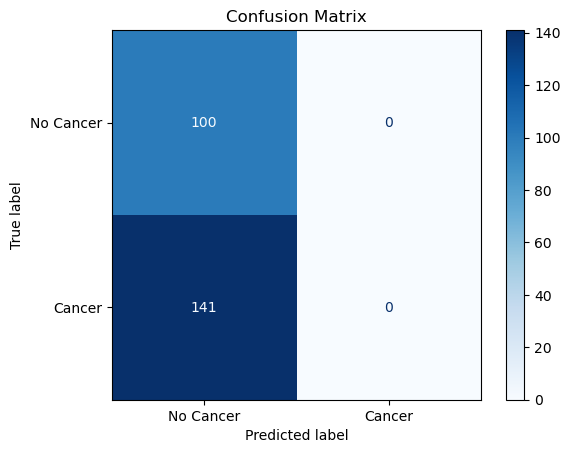

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Cancer', 'Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()